In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
# from tqdm.notebook import tqdm
from collections import defaultdict
# from tqdm.notebook import tqdm
from  sklearn.model_selection import train_test_split
pd.set_option('display.max_columns',None)
import gc
import json
import pickle
import sys
import dill
from sklearn.decomposition import PCA

In [2]:
def update_lag_time_feats(user_id,timestamp,
                         features_dicts):

    if len(features_dicts['lag_user_time'][user_id]) == 3:
        features_dicts['lag_user_time'][user_id].pop(0)
        features_dicts['lag_user_time'][user_id].append(timestamp)
    else:
        features_dicts['lag_user_time'][user_id].append(timestamp)

def update_lag_incorrect_feats(user_id,timestamp,target,
                               features_dicts):

    if target == 0:
        if len(features_dicts['lag_user_incorrect_time'][user_id]) == 1:
            features_dicts['lag_user_incorrect_time'][user_id].pop(0)
            features_dicts['lag_user_incorrect_time'][user_id].append(timestamp)
        else:
            features_dicts['lag_user_incorrect_time'][user_id].append(timestamp)


# User 組み合わせ特徴量更新
def update_user_arg_feats(user_id,col,target,
                          features_dicts,
                          ans_user_args_list_name
                        ):

    if len(features_dicts[ans_user_args_list_name][user_id][col]) == 0:
        features_dicts[ans_user_args_list_name][user_id][col] = [0,0]
    features_dicts[ans_user_args_list_name][user_id][col][1] += target
#     features_dicts[ans_user_args_list_name][user_id][col][0] += 1

# 引数特徴量更新
def update_arg_feats(col,target,
                     features_dicts,
                     ans_args_count_name, ans_args_sum_name
                     ):

    features_dicts[ans_args_count_name][col] += 1
    features_dicts[ans_args_sum_name][col] += target

# こっちは常に更新
def update_args_time_feats(col,prior_question_elapsed_time,prior_question_had_explanation,
                          features_dicts,
                           elapsed_time_args_sum_name, explanation_args_sum_name):

    features_dicts[elapsed_time_args_sum_name][col] += prior_question_elapsed_time
    features_dicts[explanation_args_sum_name][col] += prior_question_had_explanation


# Userと組み合わせ特徴量作成
def create_user_args_feats(num,user_id,col,
                           features_dicts,feats_np_dic,
                           ans_user_args_list_name = None,
                           ans_user_args_count_name = None,ans_user_args_avg_name = None):

    if len(features_dicts[ans_user_args_list_name][user_id][col]) == 0:
        features_dicts[ans_user_args_list_name][user_id][col] = [0,0]

    if features_dicts[ans_user_args_list_name][user_id][col][0] != 0:
        feats_np_dic[ans_user_args_avg_name][num] = features_dicts[ans_user_args_list_name][user_id][col][1]/features_dicts[ans_user_args_list_name][user_id][col][0]
    else:
        feats_np_dic[ans_user_args_avg_name][num] = np.nan

    feats_np_dic[ans_user_args_count_name][num] = features_dicts[ans_user_args_list_name][user_id][col][0]



def create_arg_feats(num,col,
                    features_dicts,feats_np_dic,
                    ans_count_name = None,ans_sum_name = None, elapsed_time_sum_name = None, explanation_sum_name = None,
                    ans_avg_name = None, elapsed_time_avg_name = None, explanation_avg_name = None):

    if features_dicts[ans_count_name][col] != 0:
        feats_np_dic[ans_avg_name][num] = features_dicts[ans_sum_name][col] / features_dicts[ans_count_name][col]
        feats_np_dic[elapsed_time_avg_name][num] = features_dicts[elapsed_time_sum_name][col] / features_dicts[ans_count_name][col]
        feats_np_dic[explanation_avg_name][num] = features_dicts[explanation_sum_name][col] / features_dicts[ans_count_name][col]
    else:
        feats_np_dic[ans_avg_name][num] = np.nan
        feats_np_dic[elapsed_time_avg_name][num] = np.nan
        feats_np_dic[explanation_avg_name][num] = np.nan



# ユーザー毎のlag特徴量作成
def create_lag_time_feats(num,user_id,timestamp,
                         features_dicts,
                         feats_np_dic):
    if len(features_dicts['lag_user_time'][user_id]) == 0:
        feats_np_dic['lag_time_1'][num] = np.nan
        feats_np_dic['lag_time_2'][num] = np.nan
        feats_np_dic['lag_time_3'][num] = np.nan
    elif len(features_dicts['lag_user_time'][user_id]) == 1:
        feats_np_dic['lag_time_1'][num] = timestamp - features_dicts['lag_user_time'][user_id][0]
        feats_np_dic['lag_time_2'][num] = np.nan
        feats_np_dic['lag_time_3'][num] = np.nan
    elif len(features_dicts['lag_user_time'][user_id]) == 2:
        feats_np_dic['lag_time_1'][num] = timestamp - features_dicts['lag_user_time'][user_id][1]
        feats_np_dic['lag_time_2'][num] = timestamp - features_dicts['lag_user_time'][user_id][0]
        feats_np_dic['lag_time_3'][num] = np.nan
    elif len(features_dicts['lag_user_time'][user_id]) == 3:
        feats_np_dic['lag_time_1'][num] = timestamp - features_dicts['lag_user_time'][user_id][2]
        feats_np_dic['lag_time_2'][num] = timestamp - features_dicts['lag_user_time'][user_id][1]
        feats_np_dic['lag_time_3'][num] = timestamp - features_dicts['lag_user_time'][user_id][0]

    if len(features_dicts['lag_user_incorrect_time'][user_id]) == 0:
        feats_np_dic['lag_incorrect_time'][num] = np.nan
    else:
        feats_np_dic['lag_incorrect_time'][num] = timestamp - features_dicts['lag_user_incorrect_time'][user_id][0]




# dataframeに格納するnpを一括作成
def create_datas(df):
    df_name_float_list = [
                # User
                'ans_user_avg',
                'elapsed_time_user_avg',
                'explanation_user_avg',
                # content_id
                'ans_content_avg',
                'elapsed_time_content_avg',
                'explanation_content_avg',
                # user lag time
                'lag_time_1',
                'lag_time_2',
                'lag_time_3',
                'lag_incorrect_time',
                # Tags1
                'ans_tags1_avg',
                'elapsed_time_tags1_avg',
                'explanation_tags1_avg',
                # User content
                'ans_user_content_avg',
                # User Tags1
                'ans_user_tags1_avg',
                # User Part
                'ans_user_part_avg'
    ]

    df_name_int_list = [
                # User content
                'ans_user_content_count',
                # User Tags1
                'ans_user_tags1_count',
                # Usr Part
                'ans_user_part_count'
    ]

    feats_np_dic = {}
    for name in df_name_float_list:
        feats_np_dic[name] = np.zeros(len(df), dtype = np.float32)
    for name in df_name_int_list:
        feats_np_dic[name] = np.zeros(len(df), dtype = np.int32)

    return feats_np_dic

def add_past_feature(df, features_dicts,update = True):

    # 特徴量格納dicを作成
    feats_np_dic = create_datas(df)

    for num, row in enumerate(df[['user_id', 'answered_correctly', 'content_id',
                                       'prior_question_elapsed_time', 'prior_question_had_explanation', 'timestamp',
                                       'tags1','part']].values):
        # メモリ削減のため型変換
        user_id = int(row[0])
        target = int(row[1])
        content_id = int(row[2])
        prior_question_elapsed_time = row[3]
        prior_question_had_explanation = int(row[4])
        timestamp = int(row[5])
        # Nanのときはそのまま(float)にする
        try:
            tags1 = int(row[6])
        except:
            tags1 = row[6]

        part = int(row[7])



        # lag time
        # ------------------------------------------------------------------
        create_lag_time_feats(num,user_id,timestamp,
                                features_dicts,
                                feats_np_dic)
        # 更新
        update_lag_time_feats(user_id,timestamp,
                                features_dicts)
        if update:
            update_lag_incorrect_feats(user_id,timestamp,target,
                                            features_dicts)

        # args feats
        # ------------------------------------------------------------------
        create_lists = [[user_id,
                        'ans_user_count','ans_user_sum','elapsed_time_user_sum','explanation_user_sum',                 # dic
                        'ans_user_avg','elapsed_time_user_avg','explanation_user_avg'],                                 # np
                        [content_id,
                        'ans_content_count','ans_content_sum','elapsed_time_content_sum','explanation_content_sum',     # dic
                        'ans_content_avg','elapsed_time_content_avg','explanation_content_avg'],                        # np
                        [tags1,
                        'ans_tags1_count','ans_tags1_sum','elapsed_time_tags1_sum','explanation_tags1_sum',             # dic
                        'ans_tags1_avg','elapsed_time_tags1_avg','explanation_tags1_avg']                               # np
                        ]

        for create_list in create_lists:
            create_arg_feats(num,create_list[0],
                                features_dicts,feats_np_dic,
                                create_list[1],create_list[2],create_list[3],create_list[4],
                                create_list[5],create_list[6],create_list[7])

            # 常に更新
            update_args_time_feats(create_list[0],prior_question_elapsed_time,prior_question_had_explanation,
                                        features_dicts,
                                        create_list[3],create_list[4])

            # update時のみ
            if update:
                update_arg_feats(create_list[0],target,
                                    features_dicts,
                                    create_list[1],create_list[2])

        # User args feats
        # ------------------------------------------------------------------
        create_lists = [[content_id,
                        'ans_user_content_list',                                                    # dic
                        'ans_user_content_count','ans_user_content_avg'],                           # np
                        [part,
                        'ans_user_part_list',                                                       # dic
                        'ans_user_part_count','ans_user_part_avg'],                              # np
                        [tags1,
                        'ans_user_tags1_list',                                                      # dic
                        'ans_user_tags1_count','ans_user_tags1_avg']                              # np
                        ]

        for create_list in create_lists:
            create_user_args_feats(num,user_id,create_list[0],
                                        features_dicts,feats_np_dic,
                                        create_list[1],
                                        create_list[2],create_list[3]
                                        )
            
            
            if update:
                update_user_arg_feats(user_id,create_list[0],target,
                                           features_dicts,
                                           create_list[1])


    loop_feats_df = pd.DataFrame(feats_np_dic)

    df = pd.concat([df, loop_feats_df], axis = 1)
    return df

In [3]:
def update_dics(df,features_dicts):
    for num, row in enumerate(df[['user_id', 'answered_correctly', 'content_id',
                                       'prior_question_elapsed_time', 'prior_question_had_explanation', 'timestamp',
                                       'tags1','part']].values):
        
        # メモリ削減のため型変換
        user_id = int(row[0])
        target = int(row[1])
        content_id = int(row[2])
        prior_question_elapsed_time = row[3]
        prior_question_had_explanation = int(row[4])
        timestamp = int(row[5])
        # Nanのときはそのまま(float)にする
        try:
            tags1 = int(row[6])
        except:
            tags1 = row[6]

        part = int(row[7])
        
        # lag
        update_lag_incorrect_feats(user_id,timestamp,target,features_dicts)
        
        # args
        create_lists = [[user_id,
                        'ans_user_count','ans_user_sum','elapsed_time_user_sum','explanation_user_sum',                 # dic
                        'ans_user_avg','elapsed_time_user_avg','explanation_user_avg'],                                 # np
                        [content_id,
                        'ans_content_count','ans_content_sum','elapsed_time_content_sum','explanation_content_sum',     # dic
                        'ans_content_avg','elapsed_time_content_avg','explanation_content_avg'],                        # np
                        [tags1,
                        'ans_tags1_count','ans_tags1_sum','elapsed_time_tags1_sum','explanation_tags1_sum',             # dic
                        'ans_tags1_avg','elapsed_time_tags1_avg','explanation_tags1_avg']                               # np
                        ]
        for create_list in create_lists:
            update_arg_feats(create_list[0],target,features_dicts,create_list[1],create_list[2])
        
        
        # user args
        create_lists = [[content_id,
                        'ans_user_content_list',                                                    # dic
                        'ans_user_content_count','ans_user_content_avg'],                           # np
                        [part,
                        'ans_user_part_list',                                                       # dic
                        'ans_user_part_count','ans_user_part_avg'],                              # np
                        [tags1,
                        'ans_user_tags1_list',                                                      # dic
                        'ans_user_tags1_count','ans_user_tags1_avg']                              # np
                        ]
        for create_list in create_lists:
            update_user_arg_feats(user_id,create_list[0],target,features_dicts,create_list[1])

In [4]:
class Iter_Valid(object):
    def __init__(self, df, max_user=1000):
        df = df.reset_index(drop=True)
        self.df = df
        self.user_answer = df['user_answer'].astype(str).values
        self.answered_correctly = df['answered_correctly'].astype(str).values
        df['prior_group_responses'] = "[]"
        df['prior_group_answers_correct'] = "[]"
        self.sample_df = df[df['content_type_id'] == 0][['row_id']]
        self.sample_df['answered_correctly'] = 0
        self.len = len(df)
        self.user_id = df.user_id.values
        self.task_container_id = df.task_container_id.values
        self.content_type_id = df.content_type_id.values
        self.max_user = max_user
        self.current = 0
        self.pre_user_answer_list = []
        self.pre_answered_correctly_list = []

    def __iter__(self):
        return self
    
    def fix_df(self, user_answer_list, answered_correctly_list, pre_start):
        df= self.df[pre_start:self.current].copy()
        sample_df = self.sample_df[pre_start:self.current].copy()
        df.loc[pre_start,'prior_group_responses'] = '[' + ",".join(self.pre_user_answer_list) + ']'
        df.loc[pre_start,'prior_group_answers_correct'] = '[' + ",".join(self.pre_answered_correctly_list) + ']'
        self.pre_user_answer_list = user_answer_list
        self.pre_answered_correctly_list = answered_correctly_list
        return df, sample_df

    def __next__(self):
        added_user = set()
        pre_start = self.current
        pre_added_user = -1
        pre_task_container_id = -1

        user_answer_list = []
        answered_correctly_list = []
        while self.current < self.len:
            crr_user_id = self.user_id[self.current]
            crr_task_container_id = self.task_container_id[self.current]
            crr_content_type_id = self.content_type_id[self.current]
            if crr_content_type_id == 1:
                # no more than one task_container_id of "questions" from any single user
                # so we only care for content_type_id == 0 to break loop
                user_answer_list.append(self.user_answer[self.current])
                answered_correctly_list.append(self.answered_correctly[self.current])
                self.current += 1
                continue
            if crr_user_id in added_user and ((crr_user_id != pre_added_user) or (crr_task_container_id != pre_task_container_id)):
                # known user(not prev user or differnt task container)
                return self.fix_df(user_answer_list, answered_correctly_list, pre_start)
            if len(added_user) == self.max_user:
                if  crr_user_id == pre_added_user and crr_task_container_id == pre_task_container_id:
                    user_answer_list.append(self.user_answer[self.current])
                    answered_correctly_list.append(self.answered_correctly[self.current])
                    self.current += 1
                    continue
                else:
                    return self.fix_df(user_answer_list, answered_correctly_list, pre_start)
            added_user.add(crr_user_id)
            pre_added_user = crr_user_id
            pre_task_container_id = crr_task_container_id
            user_answer_list.append(self.user_answer[self.current])
            answered_correctly_list.append(self.answered_correctly[self.current])
            self.current += 1
        if pre_start < self.current:
            return self.fix_df(user_answer_list, answered_correctly_list, pre_start)
        else:
            raise StopIteration()

In [5]:
def _label_encoder(data):
    l_data,_ =data.factorize(sort=True)
    if l_data.max()>32000:
        l_data = l_data.astype('int32')
    else:
        l_data = l_data.astype('int16')

    if data.isnull().sum() > 0:
        l_data = np.where(l_data == -1,np.nan,l_data)
    return l_data

In [6]:
def preprocessing(df,qs):
    df['prior_question_had_explanation'] = df['prior_question_had_explanation'].fillna(False)
    df.loc[df['prior_question_had_explanation'] == False , 'prior_question_had_explanation'] = 0
    df.loc[df['prior_question_had_explanation'] == True , 'prior_question_had_explanation'] = 1
    df['prior_question_had_explanation'] = df['prior_question_had_explanation'].astype('int8')
#     df['prior_question_had_explanation'] = df['prior_question_had_explanation'].astype(float)
    
    df = pd.merge(df,qs,on='content_id',how='left')
#     df = pd.concat([df.reset_index(drop=True), qs_lc.reindex(df['content_id'].values).reset_index(drop=True)], axis=1)
    df['reading_part'] = 0
    df.loc[df['part'] >=5,'reading_part'] = 1
    
    for i in range(1,7):
        df[f'tags{i}'] = df[f'tags{i}'].astype(float)

    df = df[df['content_type_id'] == 0].reset_index(drop=True)
    
    return df

In [7]:
qs = pd.read_csv('../data/input/questions.csv')
lc = pd.read_csv('../data/input/lectures.csv')
tag = qs["tags"].str.split(" ",expand = True)
tag.columns = ['tags1','tags2','tags3','tags4','tags5','tags6']
qs = pd.concat([qs,tag],axis=1)
lc['l_type_of'] = _label_encoder(lc['type_of'])
qs = qs.rename(columns={'question_id':'content_id'})
lc = lc.rename(columns={'lecture_id':'content_id'})

In [8]:
target_df = pd.read_feather('../data/train_valid/cv1_train_all.feather')
target_df = target_df[:40000000]

In [9]:
import dill
with open('../features/kernel_mini_data/loop_feats_mini.dill','rb') as f:
    features_dicts = dill.load(f)

In [10]:
iter_test = Iter_Valid(target_df,max_user=1000)
predicted = []
def set_predict(df):
    predicted.append(df)

In [11]:
pbar = tqdm(total=40000000)
previous_test_df = None
for (current_test, current_prediction_df) in iter_test:
        
    if previous_test_df is not None:
        previous_test_df['answered_correctly'] = eval(current_test["prior_group_answers_correct"].iloc[0])
        previous_test_df = preprocessing(previous_test_df,qs)
        update_dics(previous_test_df, features_dicts)

    previous_test_df = current_test.copy()
    current_test = current_test[current_test.content_type_id == 0]
    current_test = preprocessing(current_test,qs)
    current_test = add_past_feature(current_test,features_dicts,update=False)

    
    current_test['answered_correctly'] = 0.5
    set_predict(current_test.loc[:,['row_id', 'answered_correctly']])
    pbar.update(len(current_test))

  0%|          | 35070/40000000 [02:12<54:40:49, 203.02it/s]

KeyboardInterrupt: 

  0%|          | 35071/40000000 [02:30<54:40:49, 203.02it/s]

In [12]:
for i in range(0,1):
    i

In [13]:
i

0

In [2]:
l1_df = pd.read_feather('../features/kernel_mini_data/LOOP_train.feather')
b_df = pd.read_feather('../features/kernel_mini_data/BASE_train.feather')

In [3]:
l1_df = pd.concat([b_df,l1_df],axis=1)

In [6]:
l1_df['ans_user_content_avg'].mean()

0.33690938353538513

In [7]:
l1_df['ans_user_tags1_avg'].mean()

0.6909342408180237

In [9]:
l1_df[['ans_user_part_avg','part']].groupby('part').mean()

,ans_user_part_avg
part,
1,0.743858
2,0.699376
3,0.675441
4,0.593049
5,0.591837
6,0.654815
7,0.646228


In [4]:
l1_df.isnull().sum()

row_id                                     0
timestamp                                  0
user_id                                    0
content_id                                 0
content_type_id                            0
task_container_id                          0
user_answer                                0
answered_correctly                         0
prior_question_elapsed_time           121905
prior_question_had_explanation             0
bundle_id                                  0
correct_answer                             0
part                                       0
tags                                       1
tags1                                      1
tags2                               12527182
tags3                               13325566
tags4                               18889899
tags5                               23207757
tags6                               25487392
tag                                 25732027
type_of                             25732027
l_type_of 

In [10]:
l1_df['ans_user_content_avg'].isnull().sum()/len(l1_df)

0.8883579206566199

In [5]:
l1_df['days_elapsed'] = l1_df['timestamp']/(1000*3600*24)
l1_df['days_elapsed'] = l1_df['days_elapsed'].astype(int)

In [19]:
l1_df.shape

(25732027, 51)

In [31]:
qs = pd.read_csv('../data/input/questions.csv')
lc = pd.read_csv('../data/input/lectures_new.csv')
tag = qs["tags"].str.split(" ",expand = True)
tag.columns = ['tags1','tags2','tags3','tags4','tags5','tags6']
qs = pd.concat([qs,tag],axis=1)

In [51]:
lst = []
for tags in qs["tags"]:
    ohe = np.zeros(188)
    if str(tags) != "nan":
        for tag in tags.split():
            ohe += np.eye(188)[int(tag)]
    lst.append(ohe)
tags_df = pd.DataFrame(lst, columns=[f"tag_{i}" for i in range(188)]).astype(int)

In [52]:
tags_df

,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28,tag_29,tag_30,tag_31,tag_32,tag_33,tag_34,tag_35,tag_36,tag_37,tag_38,tag_39,tag_40,tag_41,tag_42,tag_43,tag_44,tag_45,tag_46,tag_47,tag_48,tag_49,tag_50,tag_51,tag_52,tag_53,tag_54,tag_55,tag_56,tag_57,tag_58,tag_59,tag_60,tag_61,tag_62,tag_63,tag_64,tag_65,tag_66,tag_67,tag_68,tag_69,tag_70,tag_71,tag_72,tag_73,tag_74,tag_75,tag_76,tag_77,tag_78,tag_79,tag_80,tag_81,tag_82,tag_83,tag_84,tag_85,tag_86,tag_87,tag_88,tag_89,tag_90,tag_91,tag_92,tag_93,tag_94,tag_95,tag_96,tag_97,tag_98,tag_99,tag_100,tag_101,tag_102,tag_103,tag_104,tag_105,tag_106,tag_107,tag_108,tag_109,tag_110,tag_111,tag_112,tag_113,tag_114,tag_115,tag_116,tag_117,tag_118,tag_119,tag_120,tag_121,tag_122,tag_123,tag_124,tag_125,tag_126,tag_127,tag_128,tag_129,tag_130,tag_131,tag_132,tag_133,tag_134,tag_135,tag_136,tag_137,tag_138,tag_139,tag_140,tag_141,tag_142,tag_143,tag_144,tag_145,tag_146,tag_147,tag_148,tag_149,tag_150,tag_151,tag_152,tag_153,tag_154,tag_155,tag_156,tag_157,tag_158,tag_159,tag_160,tag_161,tag_162,tag_163,tag_164,tag_165,tag_166,tag_167,tag_168,tag_169,tag_170,tag_171,tag_172,tag_173,tag_174,tag_175,tag_176,tag_177,tag_178,tag_179,tag_180,tag_181,tag_182,tag_183,tag_184,tag_185,tag_186,tag_187
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

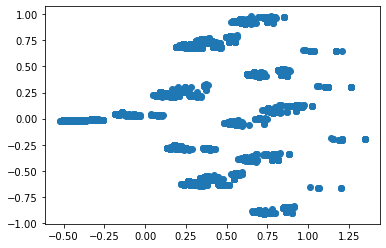

In [53]:
pca = PCA(n_components=2)

X_2d = pca.fit_transform(tags_df.values)
plt.scatter(X_2d[:,0], X_2d[:,1])

In [55]:
pca_feat_df = pd.DataFrame(X_2d, columns=["tags_pca_0", "tags_pca_1"])
pca_feat_df["question_id"] = qs["question_id"]
pca_feat_df.head()

,tags_pca_0,tags_pca_1,question_id
0,0.273486,0.709416,0
1,0.176971,-0.254628,1
2,0.303702,-0.605565,2
3,0.129849,0.245463,3
4,0.275138,0.711757,4


In [56]:
pca_feat_df.shape

(13523, 3)

In [47]:
qs[qs['tags2'] == '162']['part'].value_counts()

6    167
3     95
Name: part, dtype: int64

In [48]:
qs['tags6'].value_counts()

162    73
102    15
29      9
92      7
81      4
Name: tags6, dtype: int64

In [30]:
l1_df[l1_df['tags'] == '73']

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of,small_quenstion,prior_question_elapsed_time_mean,ans_user_avg,elapsed_time_user_avg,explanation_user_avg,ans_content_avg,elapsed_time_content_avg,explanation_content_avg,lag_time_1,lag_time_2,lag_time_3,lag_incorrect_time,ans_tags1_avg,elapsed_time_tags1_avg,explanation_tags1_avg,ans_user_content_avg,ans_user_tags1_avg,ans_user_part_avg,lag_part_time_1,lag_part_time_2,lag_part_time_3,lag_part_incorrect_time,ans_user_content_count,ans_user_tags1_count,ans_user_part_count,days_elapsed,count,paid_user
246,8681,4472195841,44331,9532,0,105,1,0,40000.0,1,9532.0,3.0,5,73,73.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,40000.0,0.550898,NaN,0.934132,NaN,NaN,NaN,130437.0,239992.0,309152.0,130437.0,NaN,NaN,NaN,NaN,NaN,0.647059,1.304370e+05,2.399920e+05,3.091520e+05,1.304370e+05,0,0,17,51,1,1
250,8685,4472501120,44331,8364,0,109,1,1,47000.0,1,8364.0,1.0,5,73,73.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,47000.0,0.549708,NaN,0.935673,NaN,NaN,NaN,112738.0,201305.0,232215.0,112738.0,0.000000,40000.000000,1.000000,NaN,0.000000,0.619048,1.127380e+05,2.013050e+05,2.322150e+05,1.127380e+05,0,1,21,51,1,1
295,8730,4545715191,44331,9113,0,148,2,0,244000.0,1,9113.0,3.0,5,73,73.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,244000.0,0.569444,NaN,0.949074,NaN,NaN,NaN,77203.0,6672988.0,6765811.0,6672988.0,0.500000,43500.000000,1.000000,NaN,0.500000,0.621622,7.720300e+04,6.672988e+06,6.765811e+06,6.672988e+06,0,2,37,52,1,1
298,8733,4545892252,44331,6314,0,151,3,1,18000.0,1,6314.0,3.0,5,73,73.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,18000.0,0.566210,NaN,0.949772,NaN,NaN,NaN,58406.0,112971.0,177061.0,112971.0,0.333333,110333.335938,1.000000,NaN,0.333333,0.600000,5.840600e+04,1.129710e+05,1.770610e+05,1.129710e+05,0,3,40,52,1,1
303,8738,4553403389,44331,9839,0,156,2,0,17000.0,1,9839.0,1.0,5,73,73.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,17000.0,0.562500,NaN,0.950893,NaN,NaN,NaN,7155949.0,7227364.0,7332148.0,7227364.0,0.500000,87250.000000,1.000000,NaN,0.500000,0.577778,7.155949e+06,7.227364e+06,7.332148e+06,7.227364e+06,0,4,45,52,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25731653,101224008,1254475404,2147375580,8572,0,73,2,1,22000.0,1,8572.0,2.0,5,73,73.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,22000.0,0.712644,NaN,0.643678,0.224238,25563.552734,0.966299,119956.0,243938.0,288486.0,339871.0,0.585826,NaN,0.910287,NaN,0.333333,0.757576,1.199560e+05,2.439380e+05,2.884860e+05,3.398710e+05,0,3,33,14,1,0
25731669,101228422,85658,2147436122,9437,0,3,2,0,18000.0,0,9437.0,1.0,5,73,73.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,18000.0,0.666667,NaN,0.000000,0.696356,26053.181641,0.918219,37602.0,58523.0,85658.0,85658.0,0.585827,NaN,0.910287,NaN,NaN,0.666667,3.760200e+04,5.852300e+04,8.565800e+04,8.565800e+04,0,0,3,0,1,0
25731777,101228736,757898,2147469944,6880,0,14,2,0,2000.0,0,6877.0,0.0,6,73,73.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,3.0,2000.0,0.391304,NaN,0.000000,0.269886,27579.501953,0.171420,0.0,212052.0,307642.0,212052.0,0.585826,NaN,0.910286,NaN,NaN,1.000000,0.000000e+00,NaN,NaN,NaN,0,0,1,0,1,1
25731963,101228923,2348442156,2147469944,10080,0,86,3,0,13666.0,1,10078.0,1.0,6,73,73.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,2.0,13666.0,0.770335,NaN,0.846890,0.811925,33451.617188,0.961067,168137.0,168137.0,168137.0,168137.0,0.585825,NaN,0.910284,NaN,0.000000,0.250000,2.347684e+09,2.347684e+09,2.347684e+09,2.347684e+09,0,1,4,27,1,1


In [27]:
l1_df['tags'].value_counts()

73                   770281
53                   668425
1                    573152
96                   508657
27                   465943
                      ...  
157 169 92               16
84 97 16 135 162         10
84 145 16 135 162        10
84 76 16 135 162         10
98 76 160 135 162         9
Name: tags, Length: 1519, dtype: int64

In [28]:
l1_df['tags1'].value_counts()

143.0    1641098
136.0    1351901
131.0    1140691
73.0      825277
74.0      759552
          ...   
19.0        2237
117.0       1302
86.0         644
160.0        414
38.0         215
Name: tags1, Length: 117, dtype: int64

In [21]:
l1_df['tags2'].isnull().sum()

12527182

In [24]:
l1_df['tags3'].unique()

array([ 81.,  92.,  29., 102.,  nan,  21., 119.,  56.,  38.,  32., 176.,
       163.,  30., 142., 100., 162.,  69., 107.,   6.,  87.,  35., 160.,
        62.,  88.,  41., 105., 117., 138., 141., 148.,  20., 186., 114.,
        71.,  18.,  97.,  76., 118.,  39., 146.,   3.,  46.,  16., 145.,
        50.,  42., 184., 185.,  77.,  59.,   0., 135.,  11., 154.])

In [25]:
l1_df['tags2'].unique()

array([ 93.,  94.,  10., 140.,  92., 162., 103.,  67.,  nan,  18.,  50.,
       118.,  19., 155.,  17.,  41., 100.,  56., 148.,  71., 143., 119.,
       114., 137.,  88.,  90.,   5.,  40., 110., 104., 164.,  70., 187.,
       105.,  20., 142., 107., 178.,  68.,  99., 163.,  38.,  81., 141.,
         2., 150.,  83., 130., 131.,  13.,  12., 149., 101.,  36., 144.,
       171., 183., 176.,  30.,  32., 185., 145.,  97.,  39.,  42., 138.,
        62.,  69., 111.,  76., 117., 169., 120., 102., 126.,  84.,   0.,
        29., 184.,  16., 153.,  37., 158., 160., 139.,  77.,  35.])

In [8]:

l1_df['count'] = 1
user_day_count = l1_df[l1_df['days_elapsed'] >= 1].groupby(['user_id','days_elapsed'])['count'].agg(['count'])
user_day_count = user_day_count.reset_index()
# 50にしておく
paid_user = user_day_count[user_day_count['count'] > 50]['user_id'].unique()

l1_df['paid_user'] = 0
l1_df.loc[l1_df['user_id'].isin(paid_user),'paid_user'] = 1

In [11]:
l1_df[l1_df['paid_user'] == 1]['user_id'].value_counts()

1047202059    16169
448193529     15164
690000616     14975
1796531206    14362
328913709     13682
              ...  
2044849273       56
1868479036       55
1660531095       55
915467896        55
706924161        54
Name: user_id, Length: 22205, dtype: int64

In [14]:
l1_df[l1_df['user_id'] == 1047202059]['answered_correctly'].mean()

0.8061104582843713

In [9]:
l1_df[['answered_correctly','paid_user','part']].groupby(['paid_user','part']).mean()

answered_correctly
paid_user part                    
0         1               0.652042
          2               0.690954
          3               0.553554
          4               0.405831
          5               0.562931
          6               0.563164
          7               0.498283
1         1               0.771254
          2               0.714904
          3               0.717280
          4               0.681228
          5               0.627833
          6               0.683847
          7               0.693141

In [15]:
l1_df[['answered_correctly','paid_user','part']].groupby(['paid_user','part']).agg(['mean']).reset_index()

,paid_user,part,answered_correctly
,,,mean
0,0,1,0.652042
1,0,2,0.690954
2,0,3,0.553554
3,0,4,0.405831
4,0,5,0.562931
5,0,6,0.563164
6,0,7,0.498283
7,1,1,0.771254
8,1,2,0.714904


In [11]:
l1_df[l1_df['paid_user'] == 1]['user_id'].nunique()

22205

In [12]:
l1_df[l1_df['paid_user'] == 0]['user_id'].nunique()

100062

In [9]:
l1_df['paid_user'].value_counts()

1    19174914
0     6557113
Name: paid_user, dtype: int64

In [20]:
l1_df = pd.concat([b_df,l1_df],axis=1)

In [26]:
l1_df[['user_id','part','timestamp','lag_time_1','lag_part_time_1','lag_part_time_2','lag_part_time_3','lag_incorrect_time','lag_part_incorrect_time']]

,user_id,part,timestamp,lag_time_1,lag_part_time_1,lag_part_time_2,lag_part_time_3,lag_incorrect_time,lag_part_incorrect_time
0,124,1,0,NaN,NaN,NaN,NaN,NaN,NaN
1,124,1,32683,32683.0,32683.0,NaN,NaN,NaN,NaN
2,124,1,62000,29317.0,29317.0,62000.0,NaN,29317.0,29317.0
3,124,2,83632,21632.0,NaN,NaN,NaN,50949.0,NaN
4,124,3,189483,105851.0,NaN,NaN,NaN,105851.0,NaN
...,...,...,...,...,...,...,...,...,...
25732022,2147469944,5,2515572144,54078.0,54078.0,103296.0,121427.0,179864.0,179864.0
25732023,2147469944,5,2515647508,75364.0,75364.0,129442.0,178660.0,255228.0,255228.0
25732024,2147469944,5,2515723695,76187.0,76187.0,151551.0,205629.0,76187.0,76187.0
25732025,2147469944,5,2516020571,296876.0,296876.0,373063.0,448427.0,296876.0,296876.0


In [23]:
l1_df[['ans_user_content_count']]

,ans_user_content_count
0,0
1,0
2,0
3,0
4,0
...,...
25732022,0
25732023,0
25732024,0
25732025,1


In [17]:
l1_df[['user_id','content_id','tags1','part','answered_correctly','ans_user_tags1_avg']][(l1_df['user_id'] == 2147469944)]

,user_id,content_id,tags1,part,answered_correctly,ans_user_tags1_avg
25731754,2147469944,7900,131.0,1,1,NaN
25731755,2147469944,7876,10.0,1,0,NaN
25731756,2147469944,175,9.0,1,1,NaN
25731757,2147469944,1278,143.0,2,0,NaN
25731758,2147469944,2065,136.0,3,1,NaN
...,...,...,...,...,...,...
25732022,2147469944,5393,133.0,5,1,0.0
25732023,2147469944,5524,91.0,5,0,NaN
25732024,2147469944,5335,58.0,5,0,0.0
25732025,2147469944,6185,58.0,5,0,0.0


In [9]:
l1_df.shape

(25732027, 19)

In [10]:
l2_df.shape

(25732027, 19)

In [25]:
LOOP1 = ['ans_user_avg','elapsed_time_user_avg','explanation_user_avg',
        'ans_content_avg','elapsed_time_content_avg','explanation_content_avg',
        'ans_user_content_count',
        'lag_time_1','lag_time_2','lag_time_3','lag_incorrect_time',
        'ans_tags1_avg','elapsed_time_tags1_avg','explanation_tags1_avg',
        'ans_user_tags1_count','ans_user_content_avg',
        'ans_user_part_count','ans_user_part_avg',
        'ans_user_tags1_avg']

In [26]:
LOOP2 = ['answered_correctly_user_avg','elapsed_time_user_avg','explanation_user_avg',\
        'answered_correctly_q_avg','elapsed_time_q_avg','explanation_q_avg',\
        'answered_correctly_uq_count','timestamp_u_recency_1','timestamp_u_recency_2',\
        'timestamp_u_recency_3','timestamp_u_incorrect_recency',\
        'answered_correctly_tags1_avg','elapsed_time_tags1_avg','explanation_tags1_avg',
        'answered_correctly_ut_count','answered_correctly_uq_avg',\
        'answered_correctly_up_count','answered_correctly_up_avg',\
        'answered_correctly_ut_avg']


In [27]:
l2_df['answered_correctly_tags1_avg'].isnull().sum()

19537801

In [3]:
for col in l1_df.columns:
    print(f'{col} : {l1_df[col].mean()}')

ans_user_avg : 0.655110239982605
elapsed_time_user_avg : 27824.826171875
explanation_user_avg : 0.655110239982605
ans_content_avg : 0.6523401737213135
elapsed_time_content_avg : 28008.626953125
explanation_content_avg : 0.6523401737213135
lag_time_1 : 11648230.0
lag_time_2 : 22805960.0
lag_time_3 : 33728940.0
lag_incorrect_time : 32878464.0
ans_tags1_avg : 0.6520004868507385
elapsed_time_tags1_avg : 28360.203125
explanation_tags1_avg : 0.6520004868507385
ans_user_content_avg : 0.6909342408180237
ans_user_tags1_avg : 0.0
ans_user_part_avg : 0.0
ans_user_content_count : 0.1509123630252681
ans_user_tags1_count : 29.36979368162485
ans_user_part_count : 266.3545656935616


In [28]:
for i in range(len(LOOP1)):
    if not (l1_df[LOOP1[i]].mean() == l2_df[LOOP2[i]].mean()):
        print(LOOP1[i],LOOP2[i])
        print(f'L1:{l1_df[LOOP1[i]].mean()} L2:{l2_df[LOOP2[i]].mean()}')
        print()

ans_tags1_avg answered_correctly_tags1_avg
L1:0.6520004868507385 L2:28360.34375

elapsed_time_tags1_avg elapsed_time_tags1_avg
L1:28360.203125 L2:28360.34375

ans_user_tags1_count answered_correctly_ut_count
L1:29.36979368162485 L2:0.0

ans_user_content_avg answered_correctly_uq_avg
L1:0.6909342408180237 L2:0.33690938353538513

ans_user_part_avg answered_correctly_up_avg
L1:0.0 L2:0.6665233969688416

ans_user_tags1_avg answered_correctly_ut_avg
L1:0.0 L2:27.443313598632812



In [23]:
l1_df['ans_user_part_avg'].value_counts()

0.0    25732027
Name: ans_user_part_avg, dtype: int64

In [30]:
l1_df = pd.concat([b_df,l1_df],axis=1)
l2_df = pd.concat([b_df,l2_df],axis=1)

In [42]:
l1_df[['user_id','content_id','ans_user_content_avg','answered_correctly']][l1_df['user_id'] == 124]

,user_id,content_id,ans_user_content_avg,answered_correctly
0,124,7900,NaN,1
1,124,7876,NaN,0
2,124,175,NaN,1
3,124,1278,NaN,0
4,124,2064,NaN,0
5,124,2063,NaN,0
6,124,2065,0.000000,1
7,124,3364,0.500000,0
8,124,3365,0.333333,0
9,124,3363,NaN,0


In [40]:
l2_df[['user_id','content_id','answered_correctly_uq_avg','answered_correctly']][l1_df['user_id'] == 124]['content_id'].value_counts()

6911    1
6910    1
2946    1
2947    1
7876    1
4492    1
2063    1
2064    1
2065    1
2948    1
4696    1
4120    1
7900    1
6173    1
3363    1
2593    1
6370    1
2595    1
3364    1
3365    1
1278    1
175     1
7216    1
7217    1
7218    1
7219    1
2594    1
6908    1
6909    1
6116    1
Name: content_id, dtype: int64

In [14]:
create_lists = [['d',
                'ans_user_count','ans_user_sum','elapsed_time_user_sum','explanation_user_sum',
                'ans_user_avg','elapsed_time_user_avg','explanation_user_avg'],
                ['c',
                'ans_content_count','ans_content_sum','elapsed_time_content_sum','explanation_content_sum',
                'ans_content_avg','elapsed_time_content_avg','explanation_content_avg'],
                ['t',
                'ans_tags1_count','ans_tags1_sum','elapsed_time_tags1_sum','explanation_tags1_sum'
                'ans_tags1_avg','elapsed_time_tags1_avg','explanation_tags1_avg']
                ]
for l in create_lists:
    l

In [15]:
l

['t',
 'ans_tags1_count',
 'ans_tags1_sum',
 'elapsed_time_tags1_sum',
 'explanation_tags1_sumans_tags1_avg',
 'elapsed_time_tags1_avg',
 'explanation_tags1_avg']

In [7]:
n = np.zeros(len(df), dtype = np.float32)

In [16]:
l = ['a','b','c','d']
for ll in l:
    d[ll] = np.zeros(len(df), dtype = np.float32)

In [22]:
d.values()

dict_values([array([100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [23]:
df = pd.DataFrame(d.values(),index=d.keys()).T

In [24]:
df

,n,a,b,c,d
0,100.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
99,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.0,0.0


In [26]:
pd.DataFrame(d)

,n,a,b,c,d
0,100.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
99,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.0,0.0


In [27]:
d

{'n': array([100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.], dtype=float32),
 'a': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0

In [10]:
d['n']

array([100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.], dtype=float32)

In [5]:
df = pd.read_csv('../data/input/example_test.csv')

In [6]:
df

,row_id,group_num,timestamp,user_id,content_id,content_type_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,prior_group_answers_correct,prior_group_responses
0,0,0,0,275030867,5729,0,0,NaN,NaN,[],[]
1,1,0,13309898705,554169193,12010,0,4427,19000.0,True,NaN,NaN
2,2,0,4213672059,1720860329,457,0,240,17000.0,True,NaN,NaN
3,3,0,62798072960,288641214,13262,0,266,23000.0,True,NaN,NaN
4,4,0,10585422061,1728340777,6119,0,162,72400.0,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
99,104,3,13167339284,1900527744,3004,0,1179,24667.0,True,NaN,NaN
100,105,3,13167339284,1900527744,3003,0,1179,24667.0,True,NaN,NaN
101,106,3,64497673060,7792299,7908,0,676,19000.0,True,NaN,NaN
102,107,3,62798166743,288641214,9077,0,269,25000.0,True,NaN,NaN


In [9]:
str(np.nan)

'nan'

In [10]:
train = pd.read_feather('../features/mini_data/BASE_train.feather')

In [16]:
train["attempt_no"] = 1
train.attempt_no=train.attempt_no.astype('int8')
#
attempt_no_agg=train[["attempt_no",'user_id','content_id']].groupby(["user_id","content_id"]).agg(['sum']).astype('int8')
#attempt_no_agg=attempt_no_agg.astype('int8')


train["attempt_no"] = train[["user_id","content_id",'attempt_no']].groupby(["user_id","content_id"])["attempt_no"].cumsum()

In [18]:
train

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of,small_quenstion,prior_question_elapsed_time_mean,attempt_no
0,46,0,124,7900,0,0,0,1,NaN,0,7900.0,0.0,1,131 93 81,131.0,93.0,81.0,NaN,NaN,NaN,NaN,None,NaN,0.0,25435.43928,1
1,47,32683,124,7876,0,1,0,0,26000.0,0,7876.0,3.0,1,10 94 92,10.0,94.0,92.0,NaN,NaN,NaN,NaN,None,NaN,0.0,26000.00000,1
2,48,62000,124,175,0,2,2,1,29000.0,0,175.0,2.0,1,9 10 92,9.0,10.0,92.0,NaN,NaN,NaN,NaN,None,NaN,0.0,29000.00000,1
3,49,83632,124,1278,0,3,1,0,26000.0,0,1278.0,3.0,2,143 140 81 29,143.0,140.0,81.0,29.0,NaN,NaN,NaN,None,NaN,0.0,26000.00000,1
4,50,189483,124,2064,0,4,2,0,18000.0,0,2063.0,1.0,3,157 92 29,157.0,92.0,29.0,NaN,NaN,NaN,NaN,None,NaN,1.0,18000.00000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40442776,101228983,2515572144,2147469944,5393,0,177,0,1,36000.0,1,5393.0,0.0,5,133,133.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,36000.00000,1
40442777,101228984,2515647508,2147469944,5524,0,178,0,0,26000.0,1,5524.0,1.0,5,91,91.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,26000.00000,1
40442778,101228985,2515723695,2147469944,5335,0,179,3,0,44000.0,1,5335.0,2.0,5,58,58.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,44000.00000,1
40442779,101228987,2516020571,2147469944,6185,0,181,0,0,39000.0,1,6185.0,3.0,5,58,58.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,39000.00000,2


In [20]:
train['user_answer']

0    11488077
1    10994880
3    10615675
2     7344149
Name: user_answer, dtype: int64

In [22]:
train.groupby(['user_id','user_answer']).cumcount()

0            0
1            1
2            0
3            0
4            1
            ..
40442776    80
40442777    81
40442778    78
40442779    82
40442780    83
Length: 40442781, dtype: int64

In [15]:
attempt_no_agg

attempt_no
                             sum
user_id    content_id           
124        175                 1
           1278                1
           2063                1
           2064                1
           2065                1
...                          ...
2147469944 10690               1
           10691               1
           10698               1
           10699               1
           10700               1

[35710205 rows x 1 columns]

In [5]:
train['tags1'].value_counts()

143.0    2599635
136.0    2099193
131.0    1759379
73.0     1319652
53.0     1204948
          ...   
19.0        3630
117.0       2110
86.0        1055
160.0        664
38.0         300
Name: tags1, Length: 117, dtype: int64

In [42]:
TARGET = 'answered_correctly'

In [2]:
valid = pd.read_feather('../data/oof/034_simple_lgb.feather')

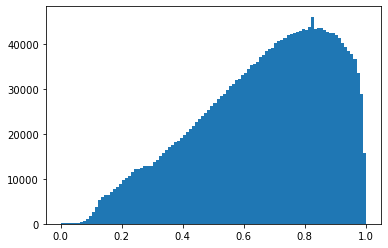

In [6]:
plt.hist(valid['pred'],bins=100)
plt.show()

In [11]:
valid

,row_id,pred
0,1874,0.822978
1,1875,0.300015
2,1876,0.359283
3,1877,0.631950
4,1878,0.329863
...,...,...
2451416,101197601,0.791046
2451417,101197602,0.596080
2451418,101197603,0.385574
2451419,101197604,0.450036


In [30]:
valid_ans = pd.read_feather('../features/mini_data/BASE_valid.feather')

In [ ]:
t = pd.read_feather('../features/mini_data/BASE_valid.feather')

In [33]:
valid_ans['prior_question_had_explanation'].value_counts()

1    2236120
0     215301
Name: prior_question_had_explanation, dtype: int64

In [47]:
task_usr = valid_ans[[TARGET,'task_container_id','user_id']].groupby(['user_id','task_container_id']).agg(['mean','count']).reset_index()

In [49]:
task_usr.columns = ['user_id','task_container_id','mean','count']

In [53]:
task_usr[task_usr['count'] == 1]['mean'].mean()

0.6578801430426858

In [60]:
task_usr[task_usr['count'] >= 3]['mean'].mean()

0.6740875007882983

In [63]:
valid_ans[(valid_ans['user_id'] == 24418) & (valid_ans['task_container_id'] == 5)]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of,small_quenstion,prior_question_elapsed_time_mean
7,1881,100241,24418,3363,0,5,0,0,4000.0,0,3363.0,3.0,4,74 103 29,74.0,103.0,29.0,NaN,NaN,NaN,NaN,None,NaN,0.0,4000.0
8,1882,100241,24418,3365,0,5,2,1,4000.0,0,3363.0,2.0,4,136 103 29,136.0,103.0,29.0,NaN,NaN,NaN,NaN,None,NaN,2.0,4000.0
9,1883,100241,24418,3364,0,5,1,1,4000.0,0,3363.0,1.0,4,136 103 29,136.0,103.0,29.0,NaN,NaN,NaN,NaN,None,NaN,1.0,4000.0


In [1]:
valid_ans['tags1'].value_counts()

NameError: name 'valid_ans' is not defined

In [67]:
valid_ans['count'] = 1
task_count = valid_ans[['count','task_container_id','user_id']].groupby(['user_id','task_container_id']).agg(['count']).reset_index()

In [86]:
task_count.columns = ['user_id','task_container_id','task_container_count']

In [87]:
valid_ans = pd.merge(valid_ans,task_count,on=['user_id','task_container_id'],how='left')

In [90]:
valid_ans[[TARGET,'task_container_count']].groupby('task_container_count').mean()

,answered_correctly
task_container_count,
1,0.657880
2,0.796368
3,0.675542
4,0.667371
5,0.692359


In [92]:
valid_ans['task_container_id'].value_counts()

14      17605
15      17505
4       15127
5       15073
6       15062
        ...  
9079        1
8925        1
9072        1
9321        1
8957        1
Name: task_container_id, Length: 9859, dtype: int64

In [93]:
dd = pd.read_feather('../features/kernel_mini_data/GROUP_BY_train.feather')

In [94]:
dd

,task_container_count
0,1
1,1
2,1
3,1
4,3
...,...
25732022,1
25732023,1
25732024,1
25732025,1


In [17]:
valid_ans = pd.merge(valid_ans,valid,on='row_id',how='left')

In [22]:
valid_ans['diff'] = valid_ans[TARGET] - valid_ans['pred']

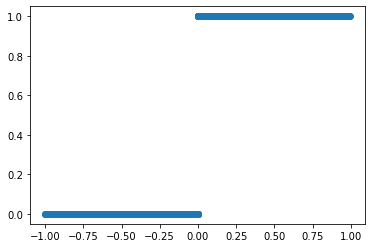

In [23]:
plt.scatter(valid_ans['diff'],valid_ans[TARGET])
plt.show()

In [27]:
valid_ans[valid_ans['diff'] < -0.9]['part'].value_counts()

5    4481
2    3855
6    2431
3    2413
1    2284
4    1776
7    1149
Name: part, dtype: int64

In [29]:
valid_ans[valid_ans['diff'] > 0.9]['part'].value_counts()

5    128
7     72
6     40
4     38
2     27
3     21
1      8
Name: part, dtype: int64

In [28]:
valid_ans['part'].value_counts()

5    1017825
2     462805
6     256191
3     215430
4     196022
1     180071
7     123077
Name: part, dtype: int64

In [25]:
valid_ans.sort_values('diff')

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of,small_quenstion,prior_question_elapsed_time_mean,pred,diff
2091628,87331204,33094223612,1858014392,7946,0,2027,1,0,20000.0,1,7946.0,2.0,1,131 149 81,131.0,149.0,81.0,NaN,NaN,NaN,NaN,None,NaN,0.0,20000.0,0.998477,-0.998477
944910,40161432,17289136417,854518136,10574,0,3086,3,0,19000.0,1,10574.0,0.0,1,131 68 92,131.0,68.0,92.0,NaN,NaN,NaN,NaN,None,NaN,0.0,19000.0,0.998109,-0.998109
584762,25102539,17603555210,536909391,10477,0,2089,2,0,25000.0,1,10477.0,0.0,1,131 149 29,131.0,149.0,29.0,NaN,NaN,NaN,NaN,None,NaN,0.0,25000.0,0.997150,-0.997150
1699915,71409670,15365252108,1519230159,742,0,2325,3,0,15000.0,1,742.0,0.0,2,143 176 38 81,143.0,176.0,38.0,81.0,NaN,NaN,NaN,None,NaN,0.0,15000.0,0.996933,-0.996933
1294908,54328659,117243979,1151429516,7963,0,69,1,0,16000.0,1,7963.0,2.0,1,131 93 38,131.0,93.0,38.0,NaN,NaN,NaN,NaN,None,NaN,0.0,16000.0,0.996889,-0.996889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2418252,99875615,2757676001,2120015219,7979,0,654,0,1,3000.0,1,7979.0,0.0,1,51 131 162 38,51.0,131.0,162.0,38.0,NaN,NaN,NaN,None,NaN,0.0,3000.0,0.024570,0.975430
2390825,98781249,6490284033,2095348710,541,0,189,3,1,17000.0,1,541.0,3.0,2,62 90 142 81 29,62.0,90.0,142.0,81.0,29.0,NaN,NaN,None,NaN,0.0,17000.0,0.013974,0.986026
1764812,74416253,16942902992,1583784120,482,0,890,3,1,8000.0,1,482.0,3.0,2,143 20 81 29,143.0,20.0,81.0,29.0,NaN,NaN,NaN,None,NaN,0.0,8000.0,0.011093,0.988907
1679725,70356743,16954162826,1496456383,1246,0,1173,3,1,16000.0,1,1246.0,3.0,2,2 32 92 29,2.0,32.0,92.0,29.0,NaN,NaN,NaN,None,NaN,0.0,16000.0,0.009558,0.990442


In [41]:
with open('../features/kernel_data/loop_feats_mini.dill','rb') as f:
    dd = dill.load(f)

In [43]:
next(iter(dd['answered_correctly_uq']))

124

In [48]:
# dd['answered_correctly_uq'][124]

In [46]:
# dd['answered_correctly_uq'][124]

In [49]:
# dd[124.0]

In [20]:
for v in dd:
    v

In [36]:
ddd = defaultdict(lambda: defaultdict(int))

In [37]:
ddd[0][0] = [0,0]
ddd[1.0][1.01] = [3,0]

In [38]:
ddd

defaultdict(<function __main__.<lambda>()>,
            {0: defaultdict(int, {0: [0, 0]}),
             1.0: defaultdict(int, {1.01: [3, 0]})})

In [23]:
v[2147362683.0]

IndexError: invalid index to scalar variable.

In [18]:
# for i in range(1,40):
#     print(i)

#     df = pd.read_feather(f'../data/train_valid/cv{i}_train.feather')
#     print(df.shape)

1
(98730332, 1)
2
(96230332, 1)
3
(93730332, 1)
4
(91230332, 1)
5
(88730332, 1)
6
(86230332, 1)
7
(83730332, 1)
8
(81230332, 1)
9
(78730332, 1)
10
(76230332, 1)
11
(73730332, 1)
12
(71230332, 1)
13
(68730332, 1)
14
(66230332, 1)
15
(63730332, 1)
16
(61230332, 1)
17
(58730332, 1)
18
(56230332, 1)
19
(53730332, 1)
20
(51230332, 1)
21
(48730332, 1)
22
(46230332, 1)
23
(43730332, 1)
24
(41230332, 1)
25
(38730332, 1)
26
(36230332, 1)
27
(33730332, 1)
28
(31230332, 1)
29
(28730332, 1)
30
(26230332, 1)
31
(23730332, 1)
32
(21230332, 1)
33
(18730332, 1)
34
(16230332, 1)
35
(13730332, 1)
36
(11230332, 1)
37
(8730332, 1)
38
(6230332, 1)
39
(3730332, 1)


In [10]:
answered_correctly_uq_dic[0][1] = 1
answered_correctly_uq_dic[0][2] = 2

In [11]:
answered_correctly_uq_dic

defaultdict(<function __main__.<lambda>()>,
            {0: defaultdict(int, {1: 1, 2: 2})})

In [2]:
a = defaultdict(int)

a['bb'] = 1
a['cc'] = 2

In [3]:
a.keys()

dict_keys(['bb', 'cc'])

In [2]:
for i in range(1,41):
    print(f'{i}')
    df = pd.read_feather(f'../data/train_valid/cv{i}_train.feather')
    print(df.shape)

1
(98730332, 1)
2
(96230332, 1)
3
(93730332, 1)
4
(91230332, 1)
5
(88730332, 1)
6
(86230332, 1)
7
(83730332, 1)
8
(81230332, 1)
9
(78730332, 1)
10
(76230332, 1)
11
(73730332, 1)
12
(71230332, 1)
13
(68730332, 1)
14
(66230332, 1)
15
(63730332, 1)
16
(61230332, 1)
17
(58730332, 1)
18
(56230332, 1)
19
(53730332, 1)
20
(51230332, 1)
21
(48730332, 1)
22
(46230332, 1)
23
(43730332, 1)
24
(41230332, 1)
25
(38730332, 1)
26
(36230332, 1)
27
(33730332, 1)
28
(31230332, 1)
29
(28730332, 1)
30
(26230332, 1)
31
(23730332, 1)
32
(21230332, 1)
33
(18730332, 1)
34
(16230332, 1)
35
(13730332, 1)
36
(11230332, 1)
37
(8730332, 1)
38
(6230332, 1)
39
(3730332, 1)
40
(1230332, 1)


In [36]:
df = pd.read_feather('../features/mini_data/BASE_train.feather')

In [37]:
df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of,small_quenstion,prior_question_elapsed_time_mean
0,8511,0,44331,5542,0,0,1,0,NaN,0,5542.0,3.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,25295.100054
1,8512,35028,44331,5697,0,1,2,0,44000.0,0,5697.0,0.0,5,14,14.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,44000.000000
2,8513,61706,44331,5748,0,2,3,1,32000.0,0,5748.0,3.0,5,8,8.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,32000.000000
3,8514,85685,44331,376,0,3,0,0,24000.0,0,376.0,1.0,2,62 90 100 38 102,62.0,90.0,100.0,38.0,102.0,NaN,NaN,None,NaN,0.0,24000.000000
4,8515,141228,44331,5597,0,4,3,1,21000.0,0,5597.0,3.0,5,64,64.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,21000.000000


In [24]:
answered_correctly_u_count = defaultdict(int)
answered_correctly_u_sum = defaultdict(int)
elapsed_time_u_sum = defaultdict(int)
explanation_u_sum = defaultdict(int)
timestamp_u = defaultdict(list)
timestamp_u_incorrect = defaultdict(list)

# Question dictionaries
answered_correctly_q_count = defaultdict(int)
answered_correctly_q_sum = defaultdict(int)
elapsed_time_q_sum = defaultdict(int)
explanation_q_sum = defaultdict(int)

# Client Question dictionary
answered_correctly_uq = defaultdict(lambda: defaultdict(int))

In [27]:
answered_correctly_u_avg = np.zeros(len(df), dtype = np.float32)
elapsed_time_u_avg = np.zeros(len(df), dtype = np.float32)
explanation_u_avg = np.zeros(len(df), dtype = np.float32)
timestamp_u_recency_1 = np.zeros(len(df), dtype = np.float32)
timestamp_u_recency_2 = np.zeros(len(df), dtype = np.float32)
timestamp_u_recency_3 = np.zeros(len(df), dtype = np.float32)
timestamp_u_incorrect_recency = np.zeros(len(df), dtype = np.float32)
# -----------------------------------------------------------------------
# Question features
answered_correctly_q_avg = np.zeros(len(df), dtype = np.float32)
elapsed_time_q_avg = np.zeros(len(df), dtype = np.float32)
explanation_q_avg = np.zeros(len(df), dtype = np.float32)
# -----------------------------------------------------------------------
# User Question
answered_correctly_uq_count = np.zeros(len(df), dtype = np.int32)
# -----------------------------------------------------------------------

for num, row in tqdm(enumerate(df[['user_id', 'answered_correctly', 'content_id', 'prior_question_elapsed_time', 'prior_question_had_explanation', 'timestamp']].values)):

    # Client features assignation
    # ------------------------------------------------------------------
    if answered_correctly_u_count[row[0]] != 0:
        answered_correctly_u_avg[num] = answered_correctly_u_sum[row[0]] / answered_correctly_u_count[row[0]]
        elapsed_time_u_avg[num] = elapsed_time_u_sum[row[0]] / answered_correctly_u_count[row[0]]
        explanation_u_avg[num] = explanation_u_sum[row[0]] / answered_correctly_u_count[row[0]]
    else:
        answered_correctly_u_avg[num] = np.nan
        elapsed_time_u_avg[num] = np.nan
        explanation_u_avg[num] = np.nan

    if len(timestamp_u[row[0]]) == 0:
        timestamp_u_recency_1[num] = np.nan
        timestamp_u_recency_2[num] = np.nan
        timestamp_u_recency_3[num] = np.nan
    elif len(timestamp_u[row[0]]) == 1:
        timestamp_u_recency_1[num] = row[5] - timestamp_u[row[0]][0]
        timestamp_u_recency_2[num] = np.nan
        timestamp_u_recency_3[num] = np.nan
    elif len(timestamp_u[row[0]]) == 2:
        timestamp_u_recency_1[num] = row[5] - timestamp_u[row[0]][1]
        timestamp_u_recency_2[num] = row[5] - timestamp_u[row[0]][0]
        timestamp_u_recency_3[num] = np.nan
    elif len(timestamp_u[row[0]]) == 3:
        timestamp_u_recency_1[num] = row[5] - timestamp_u[row[0]][2]
        timestamp_u_recency_2[num] = row[5] - timestamp_u[row[0]][1]
        timestamp_u_recency_3[num] = row[5] - timestamp_u[row[0]][0]

    if len(timestamp_u_incorrect[row[0]]) == 0:
        timestamp_u_incorrect_recency[num] = np.nan
    else:
        timestamp_u_incorrect_recency[num] = row[5] - timestamp_u_incorrect[row[0]][0]

    # ------------------------------------------------------------------
    # Question features assignation
    if answered_correctly_q_count[row[2]] != 0:
        answered_correctly_q_avg[num] = answered_correctly_q_sum[row[2]] / answered_correctly_q_count[row[2]]
        elapsed_time_q_avg[num] = elapsed_time_q_sum[row[2]] / answered_correctly_q_count[row[2]]
        explanation_q_avg[num] = explanation_q_sum[row[2]] / answered_correctly_q_count[row[2]]
    else:
        answered_correctly_q_avg[num] = np.nan
        elapsed_time_q_avg[num] = np.nan
        explanation_q_avg[num] = np.nan
    # ------------------------------------------------------------------
    # Client Question assignation
    answered_correctly_uq_count[num] = answered_correctly_uq[row[0]][row[2]]
    # ------------------------------------------------------------------
    # ------------------------------------------------------------------
    # Client features updates
    answered_correctly_u_count[row[0]] += 1
    elapsed_time_u_sum[row[0]] += row[3]
    explanation_u_sum[row[0]] += int(row[4])
    if len(timestamp_u[row[0]]) == 3:
        timestamp_u[row[0]].pop(0)
        timestamp_u[row[0]].append(row[5])
    else:
        timestamp_u[row[0]].append(row[5])
    # ------------------------------------------------------------------
    # Question features updates
    answered_correctly_q_count[row[2]] += 1
    elapsed_time_q_sum[row[2]] += row[3]
    explanation_q_sum[row[2]] += int(row[4])
    # ------------------------------------------------------------------
    # Client Question updates
    answered_correctly_uq[row[0]][row[2]] += 1
    # ------------------------------------------------------------------
    # Flag for training and inference
    if True:
        # ------------------------------------------------------------------
        # Client features updates
        answered_correctly_u_sum[row[0]] += row[1]
        if row[1] == 0:
            if len(timestamp_u_incorrect[row[0]]) == 1:
                timestamp_u_incorrect[row[0]].pop(0)
                timestamp_u_incorrect[row[0]].append(row[5])
            else:
                timestamp_u_incorrect[row[0]].append(row[5])

        # ------------------------------------------------------------------
        # Question features updates
        answered_correctly_q_sum[row[2]] += row[1]
        # ------------------------------------------------------------------


user_df = pd.DataFrame({'answered_correctly_u_avg': answered_correctly_u_avg, 'elapsed_time_u_avg': elapsed_time_u_avg, 'explanation_u_avg': explanation_u_avg, 
                        'answered_correctly_q_avg': answered_correctly_q_avg, 'elapsed_time_q_avg': elapsed_time_q_avg, 'explanation_q_avg': explanation_q_avg, 
                        'answered_correctly_uq_count': answered_correctly_uq_count, 'timestamp_u_recency_1': timestamp_u_recency_1, 'timestamp_u_recency_2': timestamp_u_recency_2,
                        'timestamp_u_recency_3': timestamp_u_recency_3, 'timestamp_u_incorrect_recency': timestamp_u_incorrect_recency})

df = pd.concat([df, user_df], axis = 1)

8568610it [02:10, 65731.72it/s]


In [33]:
# answered_correctly_q_sum

In [28]:
df

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of,small_quenstion,prior_question_elapsed_time_mean,answered_correctly_u_avg,elapsed_time_u_avg,explanation_u_avg,answered_correctly_q_avg,elapsed_time_q_avg,explanation_q_avg,answered_correctly_uq_count,timestamp_u_recency_1,timestamp_u_recency_2,timestamp_u_recency_3,timestamp_u_incorrect_recency
0,8511,0,44331,5542,0,0,1,0,NaN,0,5542.0,3.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,25295.100054,0.585616,NaN,0.958904,0.714286,NaN,0.642857,2,-4.661118e+09,-4.661118e+09,-4.661118e+09,-4.660926e+09
1,8512,35028,44331,5697,0,1,2,0,44000.0,0,5697.0,0.0,5,14,14.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,44000.000000,0.583618,NaN,0.955631,0.425000,30365.000000,0.900000,1,3.502800e+04,-4.661083e+09,-4.661083e+09,3.502800e+04
2,8513,61706,44331,5748,0,2,3,1,32000.0,0,5748.0,3.0,5,8,8.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,32000.000000,0.581633,NaN,0.952381,0.733333,25700.000000,0.333333,1,2.667800e+04,6.170600e+04,-4.661057e+09,2.667800e+04
3,8514,85685,44331,376,0,3,0,0,24000.0,0,376.0,1.0,2,62 90 100 38 102,62.0,90.0,100.0,38.0,102.0,NaN,NaN,None,NaN,0.0,24000.000000,0.583051,NaN,0.949153,0.697987,22033.556641,0.214765,1,2.397900e+04,5.065700e+04,8.568500e+04,5.065700e+04
4,8515,141228,44331,5597,0,4,3,1,21000.0,0,5597.0,3.0,5,64,64.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,21000.000000,0.581081,NaN,0.945946,0.804878,26417.683594,0.939024,2,5.554300e+04,7.952200e+04,1.062000e+05,5.554300e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8568605,101228658,219919,2147463192,6318,0,12,3,0,9000.0,1,6318.0,0.0,5,124,124.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,9000.000000,0.666667,NaN,0.333333,0.599515,NaN,0.908453,0,1.550200e+04,3.232100e+04,5.276300e+04,1.578220e+05
8568606,101228659,233275,2147463192,4756,0,13,0,0,6000.0,1,4756.0,2.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,6000.000000,0.615385,NaN,0.384615,0.724382,NaN,0.727915,0,1.335600e+04,2.885800e+04,4.567700e+04,1.335600e+04
8568607,101228660,253051,2147463192,9376,0,14,0,0,5000.0,1,9376.0,2.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,5000.000000,0.571429,NaN,0.428571,0.859195,24649.902344,0.991379,0,1.977600e+04,3.313200e+04,4.863400e+04,1.977600e+04
8568608,101228661,272506,2147463192,4447,0,15,1,1,10000.0,1,4447.0,1.0,5,47,47.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,10000.000000,0.533333,NaN,0.466667,0.707341,NaN,0.979717,0,1.945500e+04,3.923100e+04,5.258700e+04,1.945500e+04


In [29]:
answered_correctly_u_avg

array([0.5856164 , 0.58361775, 0.5816327 , ..., 0.5714286 , 0.53333336,
       0.5625    ], dtype=float32)

In [2]:
d = pd.read_feather('../features/kernel_data/content_dict.feather')

In [3]:
d.shape

(86867031, 4)

In [3]:
with open('../features/kernel_data/user_bundle_dict_sum.pkl','rb') as f:
    bundle_sum = pickle.load(f)

In [10]:
with open('../features/kernel_data/user_bundle_dict_count.pkl','rb') as f:
    bundle_count = pickle.load(f)

In [8]:
bundle_sum_key = list(bundle_sum.keys())
bundle_sum_values = list(bundle_sum.values())

In [11]:
bundle_count_key = list(bundle_count.keys())
bundle_count_values = list(bundle_count.values())

In [12]:
df_bundle_sum = pd.DataFrame()
df_bundle_sum['user_id_bundle'] = bundle_sum_key
df_bundle_sum['answered_correctly_sum_user_bundle'] = bundle_sum_values

In [13]:
df_bundle_count = pd.DataFrame()
df_bundle_count['user_id_bundle'] = bundle_count_key
df_bundle_count['count_user_bundle'] = bundle_count_values

In [14]:
df_bundle_sum.head()

,user_id_bundle,answered_correctly_sum_user_bundle
0,115-5692.0,1
1,115-5716.0,1
2,115-128.0,1
3,115-7860.0,1
4,115-7922.0,1


In [15]:
df_bundle = pd.merge(df_bundle_sum,df_bundle_count,on='user_id_bundle',how='left')

In [16]:
df_bundle['answered_correctly_avg_user_bundle'] = df_bundle['answered_correctly_sum_user_bundle'] / df_bundle['count_user_bundle']

In [17]:
df_bundle.head()

,user_id_bundle,answered_correctly_sum_user_bundle,count_user_bundle,answered_correctly_avg_user_bundle
0,115-5692.0,1,1,1.0
1,115-5716.0,1,1,1.0
2,115-128.0,1,1,1.0
3,115-7860.0,1,1,1.0
4,115-7922.0,1,1,1.0


In [53]:
df_bundle = pd.concat([df_bundle_sum.reset_index(drop=True), df_bundle_count.set_index('user_id_bundle').reindex(df_bundle_sum['user_id_bundle'].values).reset_index(drop=True)], axis=1)

In [54]:
df_bundle

,user_id_bundle,answered_correctly_sum_user_bundle,count_user_bundle
0,115-5692.0,1,1
1,115-5716.0,1,1
2,115-128.0,1,1
3,115-7860.0,1,1
4,115-7922.0,1,1
...,...,...,...
66697980,2147482888-3586.0,1,1
66697981,2147482888-6341.0,1,1
66697982,2147482888-4212.0,1,1
66697983,2147482888-6343.0,0,1


In [32]:
df_bundle_sum['user_id_bundle'].values

array(['115-5692.0', '115-5716.0', '115-128.0', ..., '2147482888-4212.0',
       '2147482888-6343.0', '2147482888-7995.0'], dtype=object)

In [51]:
df_bundle_count[df_bundle_count['user_id_bundle'].isin(['115-5692.0'])]

,user_id_bundle,count_user_bundle
0,115-5692.0,1


In [52]:
df_bundle_count.reindex(['115-5692.0'])

,user_id_bundle,count_user_bundle
115-5692.0,NaN,NaN


In [27]:
df_bundle =  pd.concat([df_bundle_count,df_bundle_sum],axis=1)

In [28]:
df_bundle

,user_id_bundle,count_user_bundle,user_id_bundle,answered_correctly_sum_user_bundle
0,115-5692.0,1,115-5692.0,1
1,115-5716.0,1,115-5716.0,1
2,115-128.0,1,115-128.0,1
3,115-7860.0,1,115-7860.0,1
4,115-7922.0,1,115-7922.0,1
...,...,...,...,...
66697980,2147482888-3586.0,1,2147482888-3586.0,1
66697981,2147482888-6341.0,1,2147482888-6341.0,1
66697982,2147482888-4212.0,1,2147482888-4212.0,1
66697983,2147482888-6343.0,1,2147482888-6343.0,0


In [24]:
df_bundle_count.head()

,user_id_bundle,count_user_bundle
0,115-5692.0,1
1,115-5716.0,1
2,115-128.0,1
3,115-7860.0,1
4,115-7922.0,1


In [25]:
df_bundle_sum.head()

,user_id_bundle,answered_correctly_sum_user_bundle
0,115-5692.0,1
1,115-5716.0,1
2,115-128.0,1
3,115-7860.0,1
4,115-7922.0,1


0

In [12]:
with open('../features/kernel_data/user_content_dict_sum.json','w') as f:
    json.dump(dic,f)

PermissionError: [Errno 13] Permission denied: '../features/kernel_data/user_content_dict_sum.json'

In [2]:
with open('../features/kernel_data/user_content_dict_sum.json','r') as f:
    j = json.load(f)

In [17]:
sys.getsizeof(j)

2684354672

In [2]:
df = pd.read_feather('../features/mini_data/BASE_train.feather')

In [57]:
import types

def imports():
    for name, val in globals().items():
        # module imports
        if isinstance(val, types.ModuleType):
            yield name, val
        # functions / callables
        if hasattr(val, '__call__'):
            yield name, val

noglobal = lambda fn: types.FunctionType(fn.__code__, dict(imports()))

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

a = 1

@noglobal
def f(b):
#     h5py.is_hdf5("a.tmp")
    # only np. shall be known, not numpy.
#     np.arange(4)
    #numpy.arange(4)
    # this var access shall break when called
#     print(a)
    print(a+b)

In [60]:
f(2)

NameError: name 'a' is not defined

In [2]:
def _reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
def add_user_feats(df, answered_correctly_sum_u_dict, count_u_dict):
    acsu = np.zeros(len(df), dtype=np.int32)
    cu = np.zeros(len(df), dtype=np.int32)
    for cnt,row in enumerate(tqdm(df[['user_id','answered_correctly']].values)):
        acsu[cnt] = answered_correctly_sum_u_dict[row[0]]
        cu[cnt] = count_u_dict[row[0]]
        answered_correctly_sum_u_dict[row[0]] += row[1]
        count_u_dict[row[0]] += 1
    user_feats_df = pd.DataFrame({'answered_correctly_sum_u':acsu, 'count_u':cu})
    user_feats_df['answered_correctly_avg_u'] = user_feats_df['answered_correctly_sum_u'] / user_feats_df['count_u']
    df = pd.concat([df, user_feats_df], axis=1)
    return df

In [11]:
train = pd.read_feather('../features/mini_data/BASE_train.feather')
valid = pd.read_feather('../features/mini_data/BASE_valid.feather')

In [14]:
answered_correctly_sum_u_dict = defaultdict(int)
count_u_dict = defaultdict(int)
train = add_user_feats(train, answered_correctly_sum_u_dict, count_u_dict)

100%|██████████| 8684585/8684585 [00:13<00:00, 665525.20it/s]


In [16]:
for cnt,row in enumerate(tqdm(valid[['user_id','answered_correctly']].values)):
#     acsu[cnt] = answered_correctly_sum_u_dict[row[0]]
    cnt
    row

100%|██████████| 2485495/2485495 [00:00<00:00, 2990517.94it/s]


In [24]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of,answered_correctly_sum_u,count_u,answered_correctly_avg_u
0,8511,0,44331,5542,0,0,1,0,NaN,NaN,5542.0,3.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0,0,NaN
1,8512,35028,44331,5697,0,1,2,0,44000.0,0.0,5697.0,0.0,5,14,14.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0,1,0.000000
2,8513,61706,44331,5748,0,2,3,1,32000.0,0.0,5748.0,3.0,5,8,8.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0,2,0.000000
3,8514,85685,44331,376,0,3,0,0,24000.0,0.0,376.0,1.0,2,62 90 100 38 102,62.0,90.0,100.0,38.0,102.0,NaN,NaN,None,NaN,1,3,0.333333
4,8515,141228,44331,5597,0,4,3,1,21000.0,0.0,5597.0,3.0,5,64,64.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,1,4,0.250000


In [29]:
# count_u_dict

In [25]:
len(answered_correctly_sum_u_dict)

52355

In [27]:
train['user_id'].nunique()

52355

In [35]:
answered_correctly_sum_u_dict = defaultdict(int)

In [36]:
answered_correctly_sum_u_dict[115] += 1

In [39]:
answered_correctly_sum_u_dict[115]

1

In [43]:
train['user_id_part'] = train['user_id'].astype(str) + '-' +train['part'].astype(str)

In [44]:
train

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of,answered_correctly_sum_u,count_u,answered_correctly_avg_u,user_id_part
0,8511,0,44331,5542,0,0,1,0,NaN,NaN,5542.0,3.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0,0,NaN,44331-5
1,8512,35028,44331,5697,0,1,2,0,44000.0,0.0,5697.0,0.0,5,14,14.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0,1,0.000000,44331-5
2,8513,61706,44331,5748,0,2,3,1,32000.0,0.0,5748.0,3.0,5,8,8.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0,2,0.000000,44331-5
3,8514,85685,44331,376,0,3,0,0,24000.0,0.0,376.0,1.0,2,62 90 100 38 102,62.0,90.0,100.0,38.0,102.0,NaN,NaN,None,NaN,1,3,0.333333,44331-2
4,8515,141228,44331,5597,0,4,3,1,21000.0,0.0,5597.0,3.0,5,64,64.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,1,4,0.250000,44331-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8684580,101228658,219919,2147463192,6318,0,12,3,0,9000.0,1.0,6318.0,0.0,5,124,124.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,9,14,0.642857,2147463192-5
8684581,101228659,233275,2147463192,4756,0,13,0,0,6000.0,1.0,4756.0,2.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,9,15,0.600000,2147463192-5
8684582,101228660,253051,2147463192,9376,0,14,0,0,5000.0,1.0,9376.0,2.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,9,16,0.562500,2147463192-5
8684583,101228661,272506,2147463192,4447,0,15,1,1,10000.0,1.0,4447.0,1.0,5,47,47.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,9,17,0.529412,2147463192-5


In [62]:
features_list = ['BASE','USER_ID','PART','USER_PART','CONTENT','USER_CONTENT','TAGS']

dfs = [pd.read_feather(f'../features/mini_data/{feature}_train.feather') for feature in features_list]
df = pd.concat(dfs,axis=1)

In [64]:
df

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of,answered_correctly_avg_user,answered_correctly_sum_user,count_user,answered_correctly_avg_part,answered_correctly_avg_user_part,answered_correctly_sum_user_part,count_user_part,answered_correctly_avg_content,answered_correctly_sum_content,content_num,answered_correctly_avg_user_content,answered_correctly_sum_user_content,count_user_content,answered_correctly_avg_tags1
0,8511,0,44331,5542,0,0,1,0,NaN,NaN,5542.0,3.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,0,0,0.602282,NaN,0,0,0.752778,271,360,NaN,0,0,0.607741
1,8512,35028,44331,5697,0,1,2,0,44000.0,0.0,5697.0,0.0,5,14,14.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.000000,0,1,0.602282,0.000000,0,1,0.579035,348,601,NaN,0,0,0.695563
2,8513,61706,44331,5748,0,2,3,1,32000.0,0.0,5748.0,3.0,5,8,8.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.000000,0,2,0.602282,0.000000,0,2,0.623457,303,486,NaN,0,0,0.610308
3,8514,85685,44331,376,0,3,0,0,24000.0,0.0,376.0,1.0,2,62 90 100 38 102,62.0,90.0,100.0,38.0,102.0,NaN,NaN,None,NaN,0.333333,1,3,0.701379,NaN,0,0,0.670373,1869,2788,NaN,0,0,0.735485
4,8515,141228,44331,5597,0,4,3,1,21000.0,0.0,5597.0,3.0,5,64,64.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.250000,1,4,0.602282,0.333333,1,3,0.828957,1168,1409,NaN,0,0,0.610358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8684580,101228658,219919,2147463192,6318,0,12,3,0,9000.0,1.0,6318.0,0.0,5,124,124.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.642857,9,14,0.602282,0.666667,8,12,0.598711,4458,7446,NaN,0,0,0.623604
8684581,101228659,233275,2147463192,4756,0,13,0,0,6000.0,1.0,4756.0,2.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.600000,9,15,0.602282,0.615385,8,13,0.722628,396,548,NaN,0,0,0.607741
8684582,101228660,253051,2147463192,9376,0,14,0,0,5000.0,1.0,9376.0,2.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.562500,9,16,0.602282,0.571429,8,14,0.860606,284,330,NaN,0,0,0.607741
8684583,101228661,272506,2147463192,4447,0,15,1,1,10000.0,1.0,4447.0,1.0,5,47,47.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.529412,9,17,0.602282,0.533333,8,15,0.707136,2091,2957,NaN,0,0,0.551334


In [65]:
df['answered_correctly_avg_user_content'].isnull().sum()

7692882

In [73]:
df['dd'] = 0
df.loc[df['user_id'] == 44331,'dd'] = 1

In [77]:
df_part_train = pd.read_feather(f'../features/mini_data/PART_train.feather')
df_part_valid = pd.read_feather(f'../features/mini_data/PART_valid.feather')

In [80]:
df_part_train['reading_part'].isnull().sum()

0

In [81]:
df_part_valid['reading_part'].isnull().sum()

0

In [3]:
train = pd.read_feather(f'../features/mini_data/BASE_train.feather')
valid = pd.read_feather(f'../features/mini_data/BASE_valid.feather')

In [87]:
train = pd.concat([train,df_part_train],axis=1)
valid = pd.concat([valid,df_part_train],axis=1)

In [89]:
train['reading_part'].isnull().sum()

0

In [90]:
valid['reading_part'].isnull().sum()

0

In [4]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of
0,8511,0,44331,5542,0,0,1,0,NaN,NaN,5542.0,3.0,5,96,96.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
1,8512,35028,44331,5697,0,1,2,0,44000.0,0.0,5697.0,0.0,5,14,14.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
2,8513,61706,44331,5748,0,2,3,1,32000.0,0.0,5748.0,3.0,5,8,8.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
3,8514,85685,44331,376,0,3,0,0,24000.0,0.0,376.0,1.0,2,62 90 100 38 102,62.0,90.0,100.0,38.0,102.0,NaN,NaN,None,NaN
4,8515,141228,44331,5597,0,4,3,1,21000.0,0.0,5597.0,3.0,5,64,64.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN


In [11]:
train['']
train[['type_of','part']].groupby('type_of').agg(['mean'])

,part
,mean
type_of,
concept,4.897378
intention,2.000000
solving question,3.748099
starter,5.000000


In [13]:
train['type_of'].fillna('NAN')

0          NAN
1          NAN
2          NAN
3          NAN
4          NAN
          ... 
8684580    NAN
8684581    NAN
8684582    NAN
8684583    NAN
8684584    NAN
Name: type_of, Length: 8684585, dtype: object

In [9]:
8568610/train.shape[0]

0.9866458788761927